[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80] (cache misses: wrong dep version loaded (2))

SYSTEM: caught exception of type :MethodError while trying to print a failed Task notice; giving up
[ Info: Precompiling IJuliaExt [2f4121a4-3b3a-5ce6-9c5e-1f2673ce168a] (cache misses: wrong dep version loaded (2))

SYSTEM: caught exception of type :MethodError while trying to print a failed Task notice; giving up


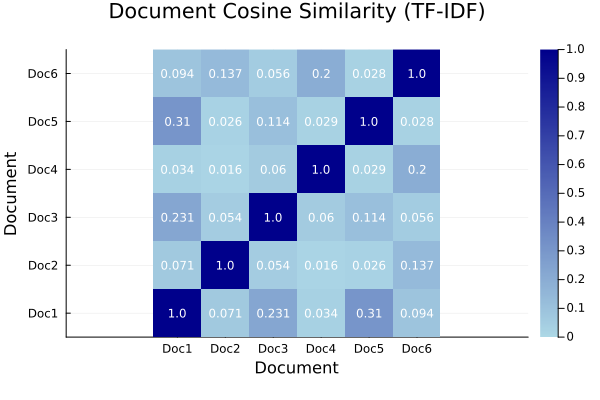

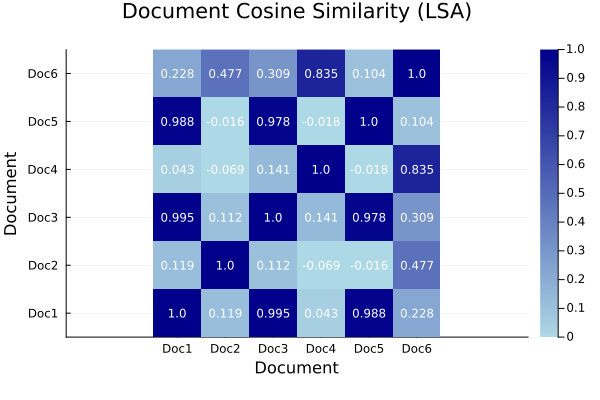


LSA-space similarity matrix (rounded to 3 decimals):
1.0	0.119	0.995	0.043	0.988	0.228	
0.119	1.0	0.112	-0.069	-0.016	0.477	
0.995	0.112	1.0	0.141	0.978	0.309	
0.043	-0.069	0.141	1.0	-0.018	0.835	
0.988	-0.016	0.978	-0.018	1.0	0.104	
0.228	0.477	0.309	0.835	0.104	1.0	

Pairs with sim ≥ 0.60 (LSA-space):
Doc 1 <-> Doc 3 : 0.995165
Doc 1 <-> Doc 5 : 0.988446
Doc 3 <-> Doc 5 : 0.977629
Doc 4 <-> Doc 6 : 0.834590

Top words per document (TF-IDF):
Doc 1: identify, moving, ships, targets, track
Doc 2: image, enhance, extract, features, noise
Doc 3: accuracy, advanced, defense, helps, improves
Doc 4: applications, classification, computer, improve, machine
Doc 5: aircraft, air, antennas, classify, on
Doc 6: deep, digital, faces, objects, patterns

Query results for: "Radar and object detection"
Doc 1 similarity: 0.996
Doc 2 similarity: 0.030
Doc 3 similarity: 0.992
Doc 4 similarity: 0.052
Doc 5 similarity: 0.996
Doc 6 similarity: 0.190


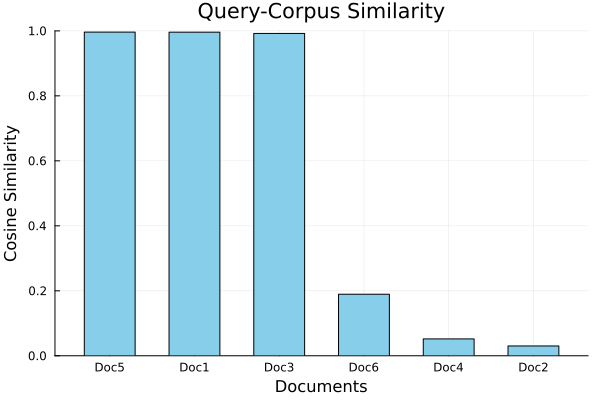

In [1]:
using LinearAlgebra, Statistics, Printf, Plots


# Corpus: six sample documents

docs = [
    "Radar detects aircraft and ships. It uses signal processing to identify and track moving targets.",
    "Image processing techniques enhance image quality, reduce noise, and extract visual features.",
    "Advanced radar signal processing improves object detection and tracking accuracy. It helps in defense systems.",
    "Machine learning models improve recognition and classification in computer vision applications.",
    "Aircraft detection radar system uses antennas to classify aircraft and vessels on the sea and air.",
    "Image recognition with deep learning detects objects, patterns, and faces in digital photos."
]
N = length(docs)


# Tokenization & vocabulary

function tokenize(s)
    s2 = replace(lowercase(s), r"[^a-z0-9\s]" => " ")
    return split(s2)
end

tokens = [tokenize(d) for d in docs]
vocab = sort(unique(reduce(vcat, tokens)))
M = length(vocab)
idx = Dict(w => i for (i,w) in enumerate(vocab))


# Term Frequency (TF) matrix

TF = zeros(Float64, M, N)
for j in 1:N
    for t in tokens[j]
        TF[idx[t], j] += 1
    end
    s = sum(TF[:,j])
    if s > 0
        TF[:,j] ./= s
    end
end


# IDF & TF-IDF

df = vec(sum(TF .> 0.0, dims=2))
idf = log.(N ./ (df .+ 1.0)) .+ 1.0
TFIDF = TF .* idf
X = TFIDF


# Cosine similarity function

cosine(a,b) = (norm(a)==0 || norm(b)==0) ? 0.0 : dot(a,b)/(norm(a)*norm(b))


# TF-IDF similarity heatmap

tfidf_sim = [cosine(TFIDF[:,i], TFIDF[:,j]) for i=1:N, j=1:N]
labels = ["Doc$(i)" for i in 1:N]

hm_tfidf = heatmap(tfidf_sim;
    xticks=(1:N, labels), yticks=(1:N, labels),
    clims=(0,1), aspect_ratio=1,
    title = "Document Cosine Similarity (TF-IDF)",
    xlabel="Document", ylabel="Document",
    color=:blues
)
for i in 1:N, j in 1:N
    annotate!(hm_tfidf, j, i, text(string(round(tfidf_sim[i,j], digits=3)), 8, :white, :center))
end
display(hm_tfidf)
savefig(hm_tfidf, "tfidf_cosine_heatmap.png")


# Latent Semantic Analysis (SVD)

F = svd(TFIDF)
k = min(3, length(F.S))  # keep top 3 latent dimensions
U_k = F.U[:,1:k]
S_k = Diagonal(F.S[1:k])
V_k = F.V[:,1:k]
doc_vectors = S_k * V_k'   # k × N

X_approx = doc_vectors

# LSA similarity

lsa_sim = [cosine(doc_vectors[:,i], doc_vectors[:,j]) for i=1:N, j=1:N]

hm_lsa = heatmap(lsa_sim;
    xticks=(1:N, labels), yticks=(1:N, labels),
    clims=(0,1), aspect_ratio=1,
    title = "Document Cosine Similarity (LSA)",
    xlabel="Document", ylabel="Document",
    color=:blues
)
for i in 1:N, j in 1:N
    annotate!(hm_lsa, j, i, text(string(round(lsa_sim[i,j], digits=3)), 8, :white, :center))
end
display(hm_lsa)
savefig(hm_lsa, "lsa_cosine_heatmap.png")



println("\nLSA-space similarity matrix (rounded to 3 decimals):")
for i in 1:N
    for j in 1:N
        print(round(lsa_sim[i,j], digits=3), "\t")
    end
    println()
end

# Documents similarity

println("\nPairs with sim ≥ 0.60 (LSA-space):")
threshold = 0.60
for i in 1:N-1, j in i+1:N
    if lsa_sim[i,j] >= threshold
        @printf("Doc %d <-> Doc %d : %.6f\n", i, j, lsa_sim[i,j])
    end
end


# Top words per document (TF-IDF)


println("\nTop words per document (TF-IDF):")
for j in 1:N
    idxs = sortperm(TFIDF[:,j], rev=true)[1:min(5,M)]
    println("Doc $j: ", join(vocab[idxs], ", "))
end


# Query projection & bar chart


function project_query_with_bar(q::String)
    
    # Tokenizing query
    
    qtok = tokenize(q)
    qvec = zeros(M)
    for t in qtok
        if haskey(idx, t)
            qvec[idx[t]] += 1
        end
    end
    if sum(qvec) == 0
        println("Query has no known terms.")
        return
    end
    qvec ./= sum(qvec)
    
    # TF-IDF for query
    
    qtfidf = qvec .* idf

    # Projection of query to LSA space
    
    qlatent = S_k \ (U_k' * qtfidf)
    if norm(qlatent) > 0
        qlatent ./= norm(qlatent)
    end

    # Cosine similarity of query with documents
    
    sims = [cosine(qlatent, doc_vectors[:,j]) for j in 1:N]

    println("\nQuery results for: \"$q\"")
    for j in 1:N
        @printf("Doc %d similarity: %.3f\n", j, sims[j])
    end

    # Bar chart showing similarity of query and documents
    
    ranking = sortperm(sims; rev=true)
    sorted_sims = sims[ranking]
    sorted_labels = ["Doc$(i)" for i in ranking]

    bar(sorted_labels, sorted_sims,
        title="Query-Corpus Similarity",
        xlabel="Documents", ylabel="Cosine Similarity",
        legend=false, ylim=(0,1),
        color=:skyblue,
        bar_width=0.6)
end


# Running Example query


project_query_with_bar("Radar and object detection")


In [8]:
## Dimensions of X before performing svd

println("Size of X: ", size(X))

Size of X: (57, 6)


In [9]:
## Dimensions of X after performing svd

println("X_approx : ", size(X_approx))

X_approx : (3, 6)


In [10]:
## Singular values of X before svd compuation


S_X = svd(X).S

6-element Vector{Float64}:
 0.6331078045697508
 0.5750437776292325
 0.5489296355236312
 0.4702203358174091
 0.44967660435077783
 0.37589857713788466

In [12]:
## Singular values of X before svd compuation

S_X_approx = svd(X_approx).S

3-element Vector{Float64}:
 0.6331078045697509
 0.5750437776292325
 0.5489296355236316